In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scikit_posthocs import posthoc_nemenyi_friedman

DOWNSAMPLING_COLORS = {
    'Decimate': '#0072B2', # Blue
    'M4': '#D55E00', # Vermilion
    'MinMax': '#009E73', # Bluish green 
    'LTTB': '#CC79A7', # Reddish purple
    'MinMaxLTTB': '#E69F00', # Orange
    'Original': 'Black'
}


data_dir = '../results'
classifier_dir = f'../results/classification'

In [2]:
class_metrics = pd.read_csv(f'{classifier_dir}/metrics_raw.csv')
class_metrics

,downsampler,factor,fold,accuracy,f1,precision,recall,roc_auc_ovr,roc_auc_ovo,sensitivity_class_0,specificity_class_0,sensitivity_class_1,specificity_class_1,sensitivity_class_2,specificity_class_2
0,Original,1,1,0.907563,0.891296,0.919520,0.870270,0.981637,0.982400,0.836735,0.978836,0.977778,0.844660,0.796296,0.989130
1,Original,1,2,0.898734,0.882574,0.901362,0.868610,0.983381,0.986077,0.714286,0.968085,0.948148,0.843137,0.943396,0.989130
2,Original,1,3,0.907173,0.893089,0.919582,0.873322,0.987222,0.988329,0.857143,0.978723,0.970370,0.843137,0.792453,0.989130
3,Original,1,4,0.945148,0.940476,0.946579,0.934773,0.988119,0.989204,0.897959,0.984043,0.962963,0.921569,0.943396,0.989130
4,Original,1,5,0.932489,0.926134,0.943344,0.911571,0.986300,0.987715,0.877551,0.984043,0.970370,0.882353,0.886792,0.994565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,MinMaxLTTB,1000,6,0.734177,0.667801,0.763795,0.645735,0.878342,0.889507,0.693878,0.941489,0.903704,0.529412,0.339623,0.978261
1306,MinMaxLTTB,1000,7,0.721519,0.636441,0.730519,0.615741,0.879807,0.892295,0.625000,0.947090,0.925926,0.509804,0.296296,0.967213
1307,MinMaxLTTB,1000,8,0.696203,0.640031,0.665904,0.639660,0.861575,0.878337,0.770833,0.915344,0.814815,0.578431,0.333333,0.928962
1308,MinMaxLTTB,1000,9,0.725738,0.668515,0.738950,0.640432,0.852655,0.868385,0.625000,0.952381,0.888889,0.529412,0.407407,0.956284


In [3]:
with open(f'{data_dir}/preprocessed/metadata.json') as f:
    metadata = json.load(f)
    mapping = list(metadata['num_samples_per_class'].keys())
metadata

{'fs': 23437.5,
 'class_mapping': {'ALS': 0, 'Control': 1, 'Myopathic': 2},
 'num_samples_per_class': {'ALS': 486, 'Control': 1350, 'Myopathic': 535},
 'samples_per_fragment': 46875,
 'X_samples': 2371,
 'y_samples': 2371}

In [4]:
def test_significant_difference(metrics, tested_method, tested_factor, reference_method, reference_factor, alpha=0.05):
    tested_acc = metrics[(metrics['downsampler'] == tested_method) & (metrics['factor'] == tested_factor)]['accuracy']
    reference_acc = metrics[(metrics['downsampler'] == reference_method) & (metrics['factor'] == reference_factor)]['accuracy']
    
    test_data = pd.DataFrame({
        f'{tested_method}({tested_factor})': tested_acc.values,
        f'{reference_method}({reference_factor})': reference_acc.values
    })
    
    nemenyi_result = posthoc_nemenyi_friedman(test_data)
    p_val = nemenyi_result.iloc[0, 1]
    
    if p_val < alpha:
        return True, p_val, tested_acc.mean()
    else:
        return False, p_val, tested_acc.mean()


def find_first_significant_difference(metrics, tested_method, reference_method, reference_factor, alpha=0.05):
    factors = sorted(metrics[metrics['downsampler'] == tested_method]['factor'].unique())
    for factor in factors:
        diff, p_val, mean_acc = test_significant_difference(
            metrics, tested_method, factor, reference_method, reference_factor, alpha
        )
        if diff:
            return factor, p_val, mean_acc
    return None, None, None


def find_first_significant_difference_each_method(metrics, reference_method, reference_factor, alpha=0.05):
    significance_points = {}
    for method in metrics['downsampler'].unique():
        if method == reference_method:
            continue
        factor, p_val, mean_acc = find_first_significant_difference(metrics, method, reference_method, reference_factor, alpha)
        significance_points[method] = (factor, p_val, mean_acc)
    return significance_points

significance_points = find_first_significant_difference_each_method(class_metrics, 'Original', 1, alpha=0.05)
significance_points

{'Decimate': (np.int64(10),
  np.float64(0.011412036386001634),
  np.float64(0.91228060844591)),
 'LTTB': (np.int64(35),
  np.float64(0.011412036386001634),
  np.float64(0.8970960536113178)),
 'MinMax': (np.int64(25),
  np.float64(0.011412036386001634),
  np.float64(0.8987855901854411)),
 'M4': (np.int64(10),
  np.float64(0.004426525857919805),
  np.float64(0.9025830585398715)),
 'MinMaxLTTB': (np.int64(35),
  np.float64(0.011412036386001634),
  np.float64(0.8987784987412688))}

In [5]:
data = class_metrics[class_metrics['factor'] <= 50].copy()
agg = data.groupby(['downsampler', 'factor'])['accuracy'].agg(['mean', 'std']).reset_index()

downsamplers = agg['downsampler'].unique()
factors = agg['factor'].unique()

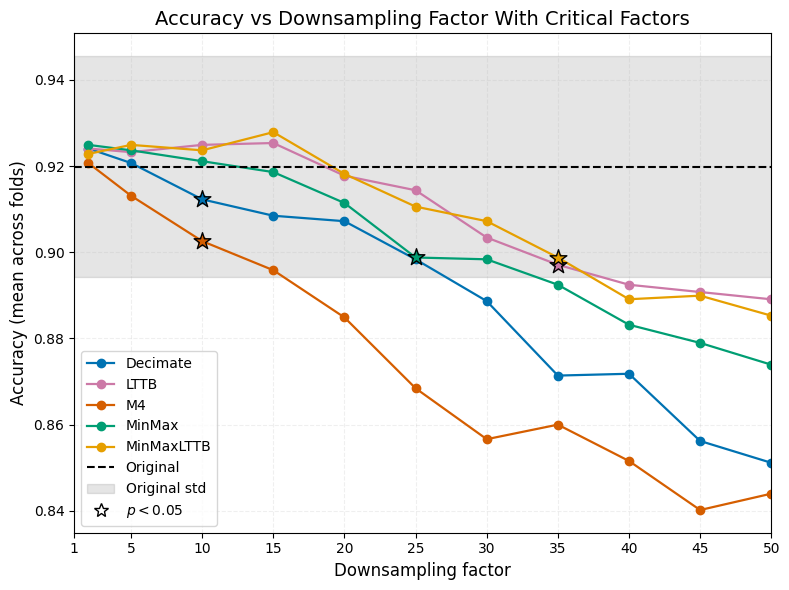

In [6]:
fig, ax = plt.subplots(figsize=(8,6))
sig_conf = {point[0]: int(point[1][0]) for point in significance_points.items()}
sig_conf['Original'] = -1

star_legend_handle = Line2D([0], [0], marker='*', color='w',markerfacecolor='white', markeredgecolor='black', markersize=10, linestyle='None')
star_legend_label = r'$p < 0.05$'
handles = []
labels = []

for i, ds in enumerate(downsamplers):
    ds_df = agg[agg['downsampler'] == ds].set_index('factor').sort_index()

    if 1 in ds_df.index:
        orig_mean = ds_df.loc[1, 'mean']
        orig_std = ds_df.loc[1, 'std']
        
        line = ax.hlines(orig_mean, min(factors), max(factors), linestyles='--', color=DOWNSAMPLING_COLORS[ds], label='Original')
        handles.append(line)
        labels.append('Original')

        line = ax.fill_between([1, 100], orig_mean - orig_std, orig_mean + orig_std, color=DOWNSAMPLING_COLORS[ds], alpha=0.1, label='Original std')
        handles.append(line)
        labels.append('Original std')

    ds_plot = ds_df[ds_df.index > 1]
    
    if ds_plot is not None and not ds_plot.empty:
        x = ds_plot.index.values
        y = ds_plot['mean'].values
        line, = ax.plot(x, y, marker='o', linewidth=1.6, markersize=6, color=DOWNSAMPLING_COLORS[ds], label=ds)

        handles.append(line)
        labels.append(ds)

for ds, (sig_factor, sig_p, sig_mean) in significance_points.items():
    ax.scatter(sig_factor, sig_mean, color=DOWNSAMPLING_COLORS[ds], marker="*", edgecolors='black', s=160, zorder=5)


ax.set_xlabel('Downsampling factor', fontsize=12)
ax.set_ylabel('Accuracy (mean across folds)', fontsize=12)
ax.set_title('Accuracy vs Downsampling Factor With Critical Factors', fontsize=14)
ax.set_xticks(factors[1:])
ax.set_xlim(min(factors), max(factors))
ax.grid(alpha=0.2, linestyle='--')

handles.append(star_legend_handle)
labels.append(star_legend_label)

ax.legend(handles, labels, loc='lower left')
plt.tight_layout()
plt.show()

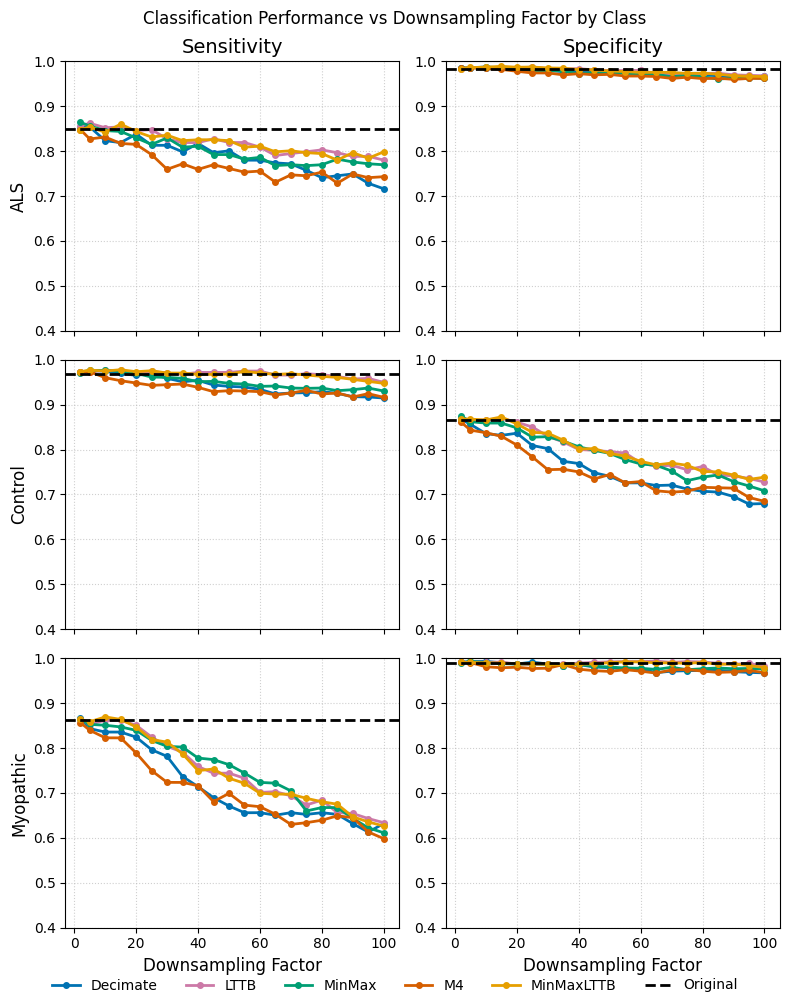

In [7]:
data = class_metrics[class_metrics['factor'] <= 100].copy()
fig, axs = plt.subplots(3, 2, figsize=(8, 10), sharex=True)
classes = [0, 1, 2]
metrics_names = ['Sensitivity', 'Specificity']
downsamplers = [d for d in data['downsampler'].unique() if d != 'Original']
all_handles = []
all_labels = []

for col, metric_name in enumerate(metrics_names):
    metric_key = metric_name.lower()
    
    for row, cls in enumerate(classes):
        ax = axs[row, col]
        for downsampler in downsamplers:
            subset = data[data['downsampler'] == downsampler]
            means = subset.groupby('factor')[f'{metric_key}_class_{cls}'].mean()
            line, = ax.plot(means.index, means.values, label=downsampler, color=DOWNSAMPLING_COLORS[downsampler], marker='o', markersize=4, linewidth=2)
            if row == 0 and col == 0:
                all_handles.append(line)
                all_labels.append(downsampler)
        
        original_value = data[data['downsampler'] == 'Original'][f'{metric_key}_class_{cls}'].mean()
        ax.set_ylim(0.4, 1)

        if row == 0 and col == 0:
            original_line = ax.axhline(y=original_value, color=DOWNSAMPLING_COLORS['Original'], linestyle='--', label='Original', linewidth=2)
            all_handles.append(original_line)
            all_labels.append('Original')
        else:
            ax.axhline(y=original_value, color=DOWNSAMPLING_COLORS['Original'], linestyle='--', linewidth=2)
        
        if row == 2:
            ax.set_xlabel('Downsampling Factor', fontsize=12)
        if col == 0:
            ax.set_ylabel(mapping[cls], fontsize=12)
        if row == 0:
            ax.set_title(metric_name, fontsize=14)
        ax.grid(True, linestyle=':', alpha=0.6)

fig.legend(all_handles, all_labels, loc='lower center', bbox_to_anchor=(0.5, -0.015), ncol=len(all_labels), fontsize=10, frameon=False)
fig.suptitle('Classification Performance vs Downsampling Factor by Class')
plt.tight_layout()

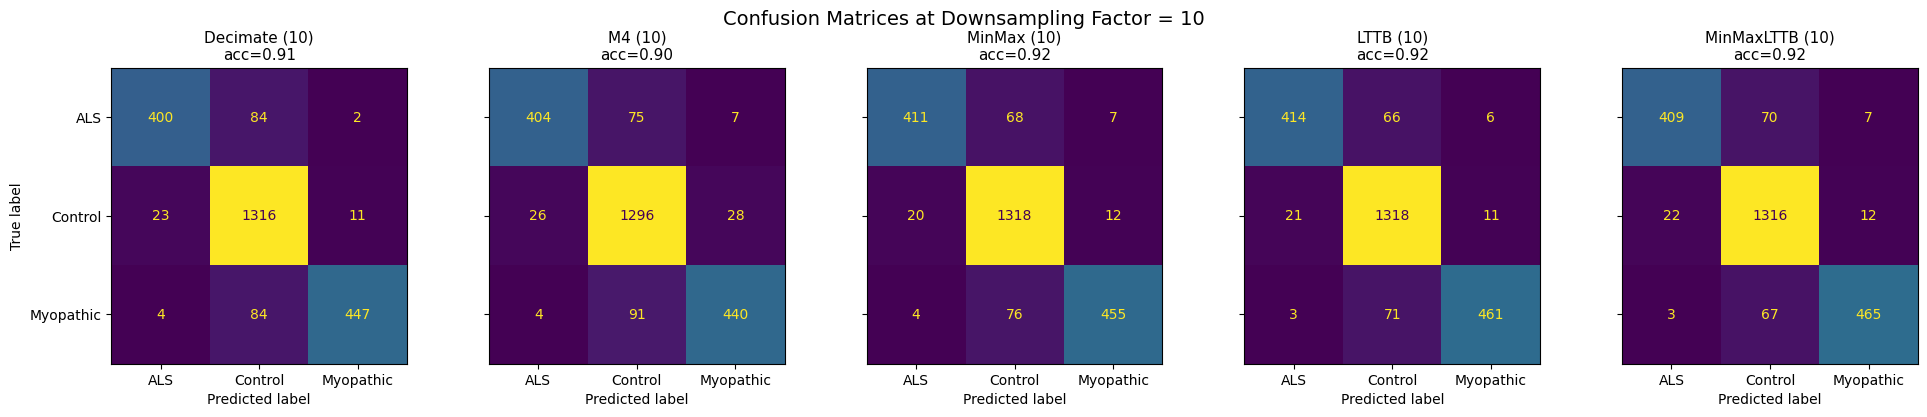

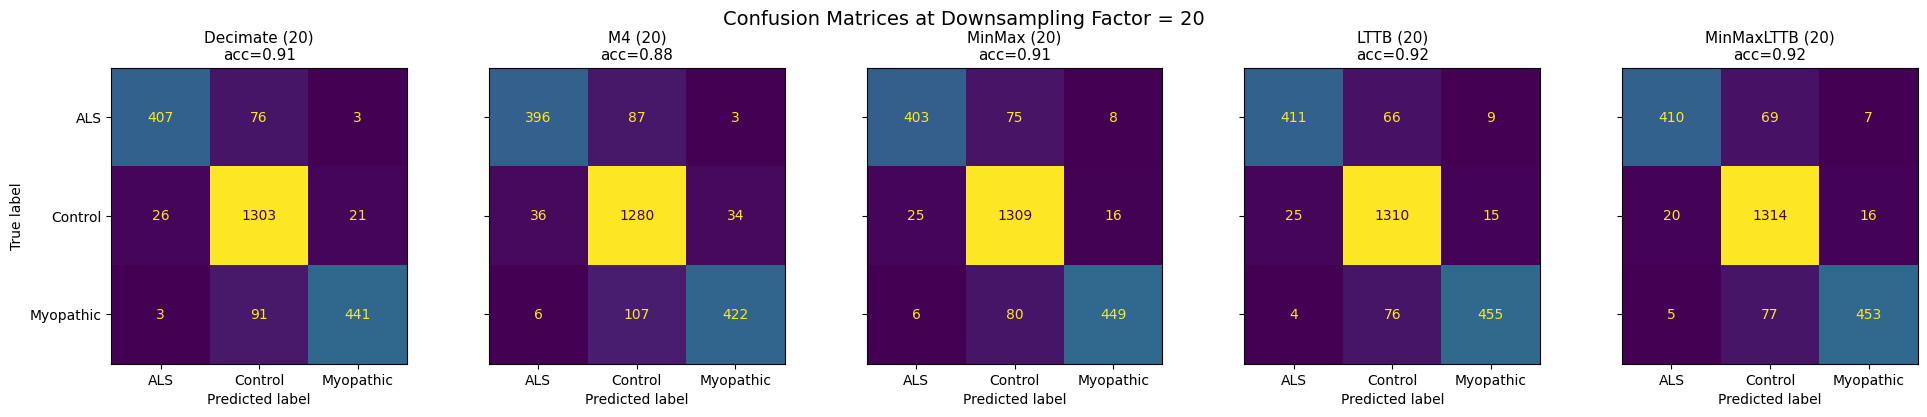

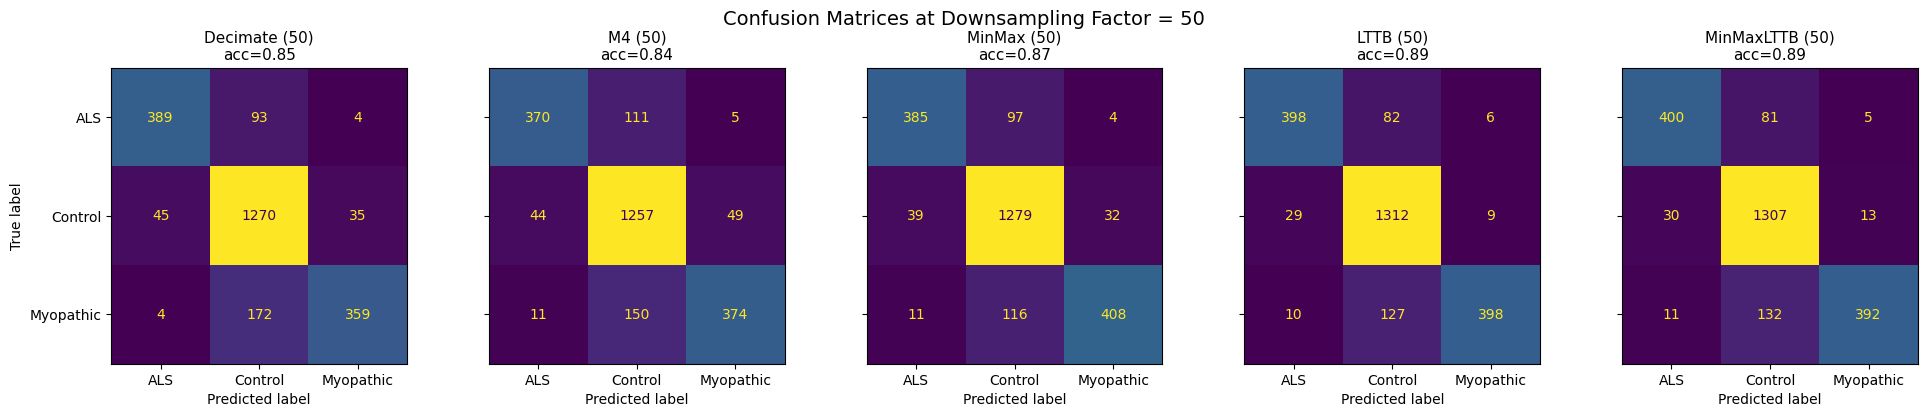

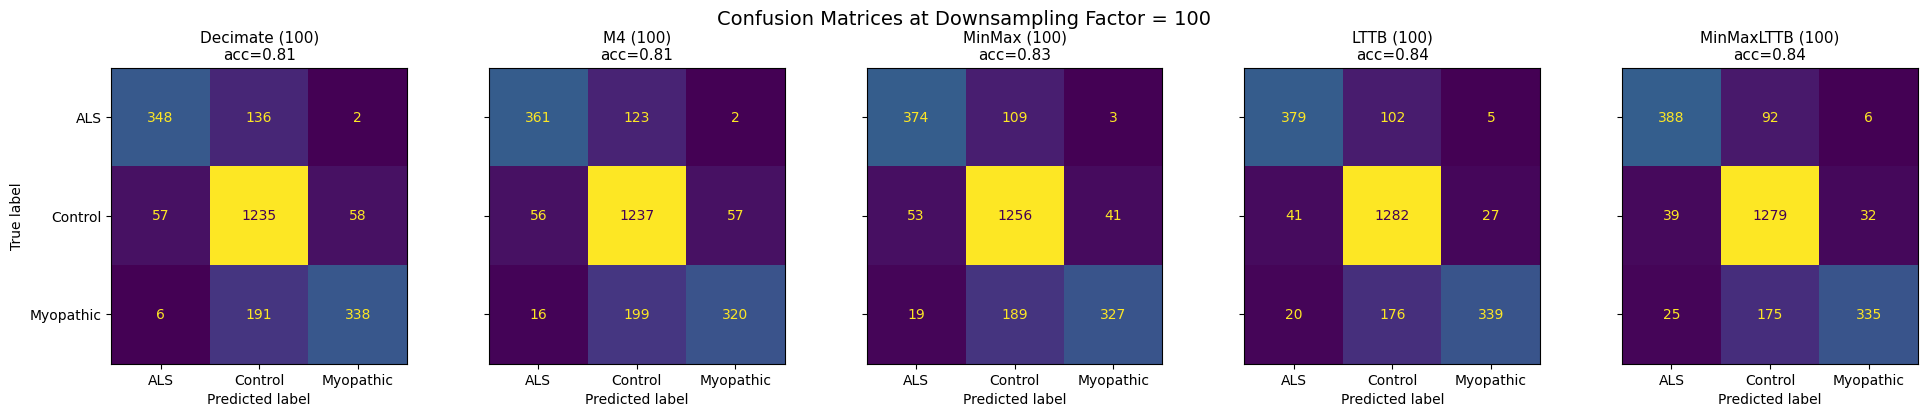

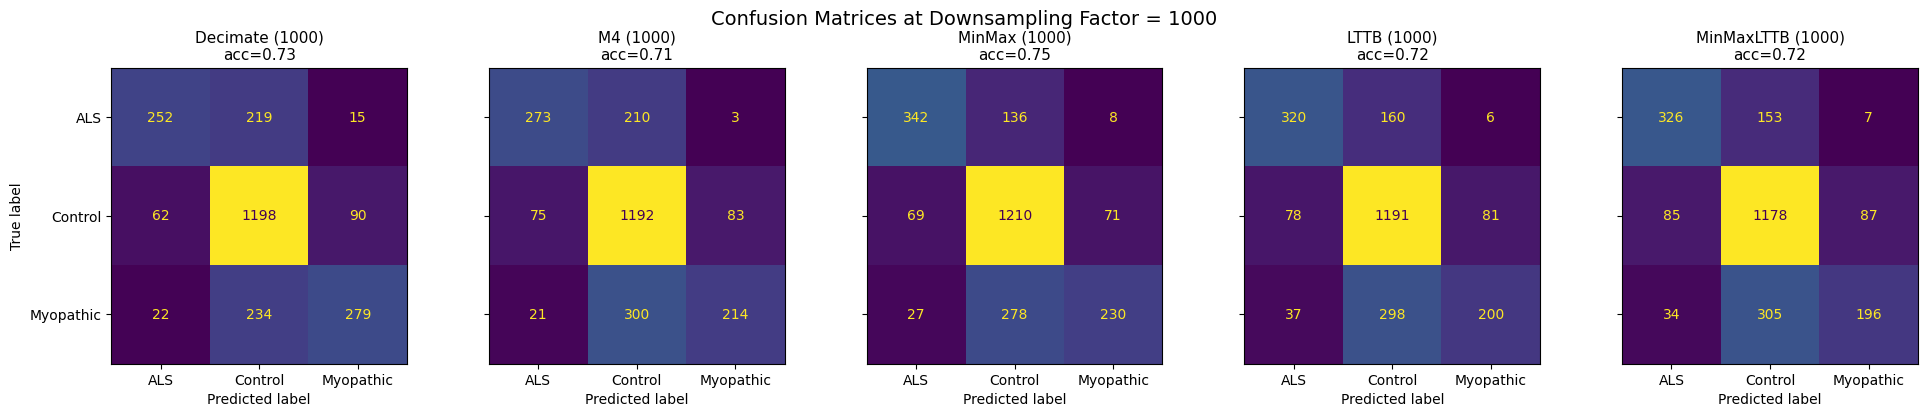

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrices_for_factor(factor, downsamplers, classifier_dir):
    n = len(downsamplers)
    fig, axes = plt.subplots(1, n, figsize=(4 * n, 4), sharey=True)
    
    if n == 1:
        axes = [axes]

    for ax, downsampler in zip(axes, downsamplers):
        y_pred = np.load(f'{classifier_dir}/{downsampler}/{factor}/y_pred.npy')
        y_true = np.load(f'{classifier_dir}/{downsampler}/{factor}/y_true.npy')

        cm = confusion_matrix(y_true, y_pred)
        acc = accuracy_score(y_true, y_pred)

        disp = ConfusionMatrixDisplay(cm, display_labels=mapping)
        disp.plot(ax=ax, colorbar=False)

        ax.set_title(f'{downsampler} ({factor})\nacc={acc:.2f}', fontsize=11)
        ax.set_xlabel('Predicted label')
        if ax is axes[0]:
            ax.set_ylabel('True label')
        else:
            ax.set_ylabel('')

    fig.suptitle(f'Confusion Matrices at Downsampling Factor = {factor}', fontsize=14)
    plt.tight_layout()
    plt.show()

downsamplers = ['Decimate', 'M4', 'MinMax', 'LTTB', 'MinMaxLTTB']
plot_confusion_matrices_for_factor(factor=10, downsamplers=downsamplers, classifier_dir=classifier_dir)
plot_confusion_matrices_for_factor(factor=20, downsamplers=downsamplers, classifier_dir=classifier_dir)
plot_confusion_matrices_for_factor(factor=50, downsamplers=downsamplers, classifier_dir=classifier_dir)
plot_confusion_matrices_for_factor(factor=100, downsamplers=downsamplers, classifier_dir=classifier_dir)
plot_confusion_matrices_for_factor(factor=1000, downsamplers=downsamplers, classifier_dir=classifier_dir)